# Introduction:

The purpose of this project is to calculate and evaluate return statistics for panel data in Python and further evaluate popular sayings in financial markets. In this case we’re looking at whether the correlations between S&P 500 and certain organizations during the crisis go to 1 or not. Additionally, verifying if there’s a similar pattern that is followed for CAPM (Capital Asset Pricing Model) betas.

We have defined crisis as follows:
1.	Begins with a bear market, which is a 20% decline in the S&P 500 from its recent peak. 
2.	Ends with the next bull market, which is a 20% rise in the S&P 500 from its recent trough.

# Methodology

1. We gathered all the prior data to identify the peaks and troughs which further helped us in identifying the crisis period.
1. Further, we calculated the returns of the stock from 1980-2023.
1. After identifying the periods in which crises occurred, we filtered the data according to specific intervals i.e. monthly and quarterly periods.
1. After identifying the crisis period and filtering it out according to our desired time periods, we calculated the average correlations between the S&P 500 and the returns on the stock of different organizations, the monthly and quarterly betas further calculating the median and the standard deviation.


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_datareader as pdr
%config InlineBackend.figure_format = 'retina'

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tickers = pd.read_html(io=url)[0]['Symbol'].to_list()
# Wikipedia uses "." in tickers, but Yahoo! Finance uses "-" in tickers
tickers = [t.replace('.', '-') for t in tickers]
tickers[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [3]:
def get_data(tickers, index, start, end, file):
    (
        yf.download(tickers=tickers, start=start, end=end)
        ['Adj Close']
        .pct_change()
        .join(
            other=(
                # get all prior index data to identify peaks and troughs (and bear and bull markets)
                yf.download(tickers=index, start='1900-01-01', end=end)
                [['Close']]
                .rename(columns={'Close': index})
            ),
            how='outer'
        )
        .to_csv(file)
    )

In [4]:
get_data(tickers=tickers, index='^GSPC', start='1980-01-01', end='2023-12-31', file='sp500.csv')

[*********************100%%**********************]  503 of 503 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
sp500 = (
    pd.read_csv(
        filepath_or_buffer='sp500.csv',
        parse_dates=['Date'],
        index_col=['Date']
    )
    .rename_axis(columns='Ticker')
)

sp500.iloc[-5:, -5:].pipe(display)

Ticker,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,
2023-12-22,0.000154,0.007605,0.015454,0.001644,4754.629883
2023-12-26,0.002000,0.009142,0.022605,0.002667,4774.750000
2023-12-27,0.004453,-0.002388,0.001053,0.007161,4781.580078
2023-12-28,-0.002446,0.004128,-0.001595,0.001320,4783.350098
2023-12-29,0.001073,0.000576,-0.007336,0.001065,4769.830078


# Computation of Crisis Periods

In [6]:
sp500_df = pd.read_csv('sp500.csv')
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
filtered_sp500_df = sp500_df[(sp500_df['Date'].dt.year >= 1980) & (sp500_df['Date'].dt.year <= 2023)]

In [7]:
filtered_sp500_df['Daily Returns'] = filtered_sp500_df['^GSPC'].pct_change()

In [8]:
crisis_periods = []
troughs_info = []
peak = filtered_sp500_df['^GSPC'].iloc[0]
peak_date = filtered_sp500_df['Date'].iloc[0]
trough = peak
trough_date = peak_date
in_crisis = False

for i, row in filtered_sp500_df.iterrows():
    price = row['^GSPC']
    date = row['Date']
    
    if not in_crisis and price > peak:
        peak = price
        peak_date = date
    
    if not in_crisis and price <= peak * 0.8:
        # Crisis starts
        in_crisis = True
        trough = price
        trough_date = date
        crisis_start = date
        
    elif in_crisis:
        if price < trough:
            trough = price
            trough_date = date
            
        if price >= trough * 1.2:
            crisis_periods.append((peak_date, crisis_start, trough_date, date))
            in_crisis = False
            peak = price
            peak_date = date

crisis_periods_df = pd.DataFrame(crisis_periods, columns=['Peak Date', 'Crisis Start', 'Trough Date', 'Crisis End'])

crisis_periods_df

,Peak Date,Crisis Start,Trough Date,Crisis End
0,1980-11-28,1982-02-22,1982-08-12,1982-09-14
1,1987-08-25,1987-10-19,1987-12-04,1988-03-08
2,2000-03-24,2001-03-12,2001-09-21,2001-12-05
3,2002-01-04,2002-07-10,2002-07-23,2002-08-22
4,2007-10-09,2008-07-09,2008-11-20,2008-12-08
5,2009-01-06,2009-02-23,2009-03-09,2009-03-23
6,2020-02-19,2020-03-12,2020-03-23,2020-04-08
7,2022-01-03,2022-06-13,2022-10-12,2023-06-08


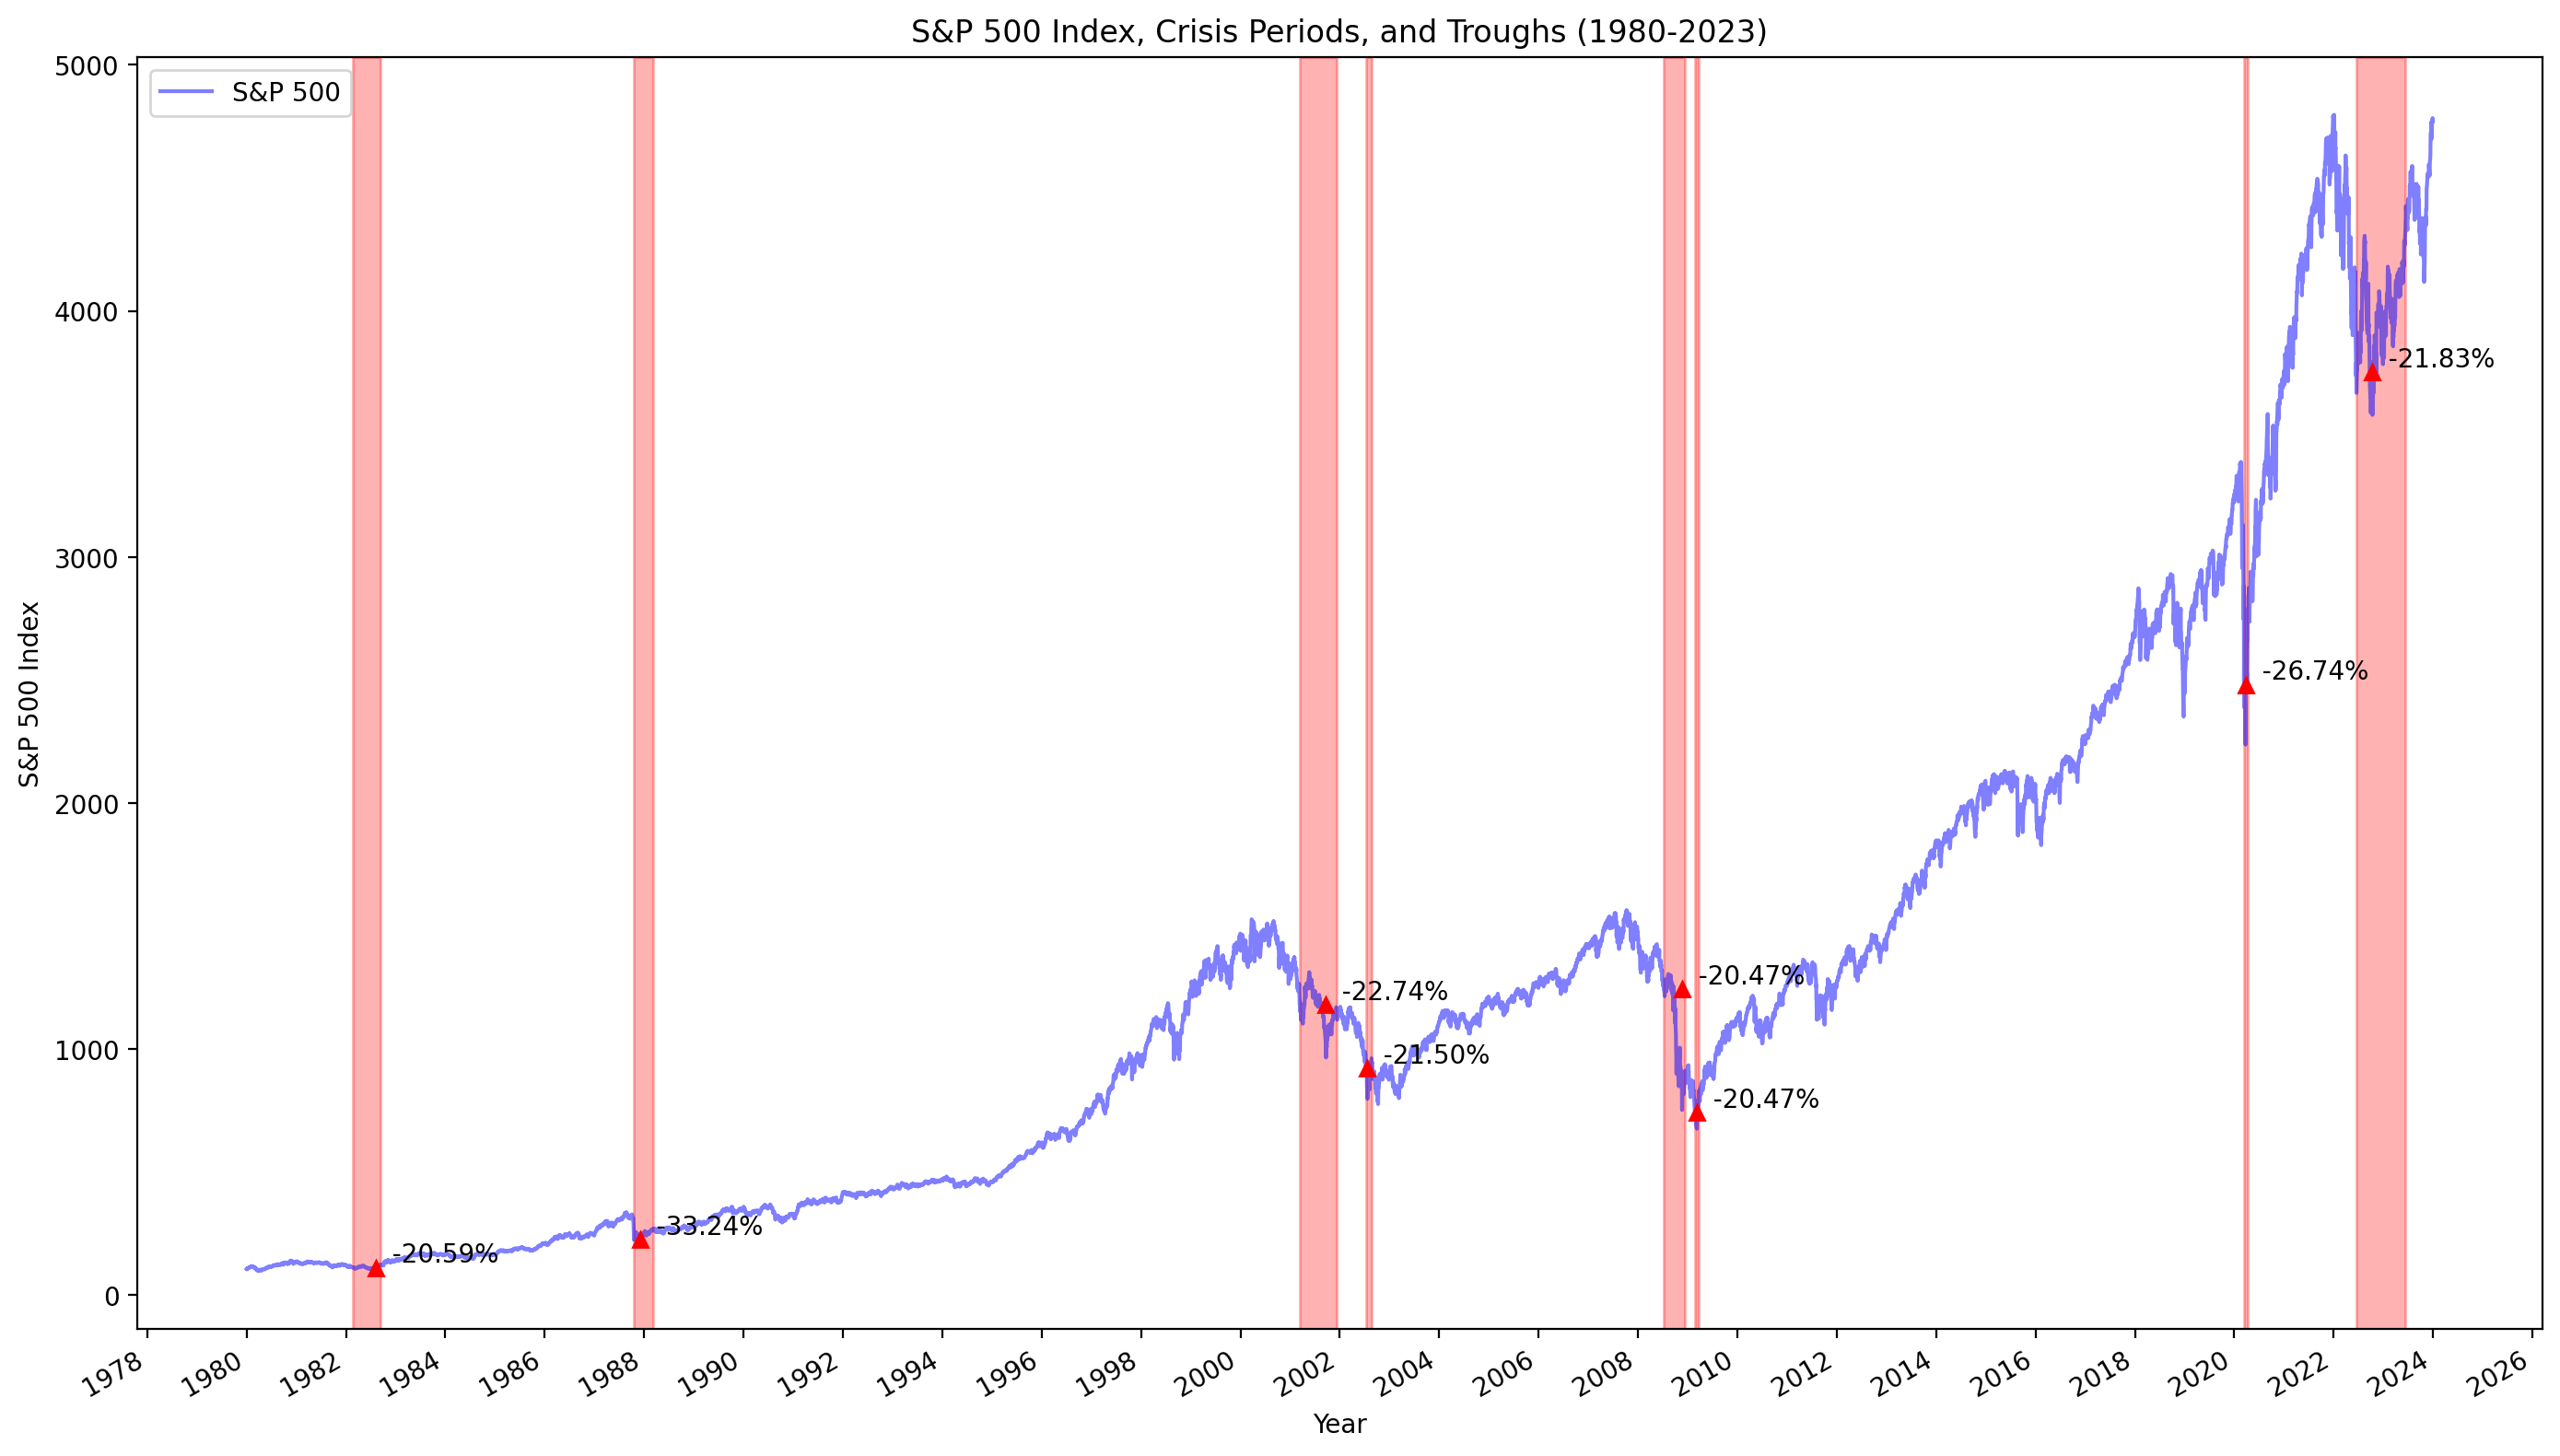

In [9]:
plt.figure(figsize=(14, 8))
plt.plot(filtered_sp500_df['Date'], filtered_sp500_df['^GSPC'], label='S&P 500', color='blue', alpha=0.5)

for index, row in crisis_periods_df.iterrows():
    plt.axvspan(row['Crisis Start'], row['Crisis End'], color='red', alpha=0.3)

for _, row in crisis_periods_df.iterrows():
    peak_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Peak Date']]['^GSPC'].values[0]
    trough_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Crisis Start']]['^GSPC'].values[0]
    percent_drop = ((trough_price - peak_price) / peak_price) * 100
    plt.plot(row['Trough Date'], trough_price, 'r^')  # Red triangle for trough
    plt.text(row['Trough Date'], trough_price, f'  {percent_drop:.2f}%', verticalalignment='bottom')

plt.title('S&P 500 Index, Crisis Periods, and Troughs (1980-2023)')
plt.xlabel('Year')
plt.ylabel('S&P 500 Index')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotation

plt.tight_layout()
plt.show()

# Computation of Correlation

In [10]:
Data = sp500.loc['1980-01-01':'2023-12-31']

In [11]:
DataCorr = Data.drop(columns=Data.columns[-2:])

In [12]:
rolling_window = 12 
Correlation_Matrix = (
    DataCorr
    .resample('M').last()
    .rolling(window = rolling_window, min_periods=1).corr()
)

In [13]:
unique_dates = Correlation_Matrix.index.get_level_values('Date').unique()
sliced_dfs = []
for date in unique_dates:
    sliced_df = Correlation_Matrix.loc[date]
    sliced_dfs.append(sliced_df)

In [14]:
means = []
for sliced_df in sliced_dfs:
    matrix_array = sliced_df.values
    matrix_mean = np.nanmean(matrix_array)
    means.append(matrix_mean)

## Monthly Correlation

In [15]:
mean_date_df_m = pd.DataFrame({'Date': unique_dates, 'Mean': means})

In [16]:
std_devs = []
for sliced_df in sliced_dfs:
    matrix_array = sliced_df.values
    matrix_std_dev = np.nanstd(matrix_array)
    std_devs.append(matrix_std_dev)

In [17]:
mean_date_df_m['Standard Deviation'] = std_devs
mean_date_df_m

,Date,Mean,Standard Deviation
0,1980-01-31,NaN,NaN
1,1980-02-29,0.223282,0.974754
2,1980-03-31,0.295576,0.663351
3,1980-04-30,0.243245,0.843682
4,1980-05-31,0.160467,0.643890
...,...,...,...
523,2023-08-31,0.456396,0.264673
524,2023-09-30,0.431715,0.270316
525,2023-10-31,0.416939,0.272551
526,2023-11-30,0.335052,0.296232


Text(0, 0.5, 'Correlation')

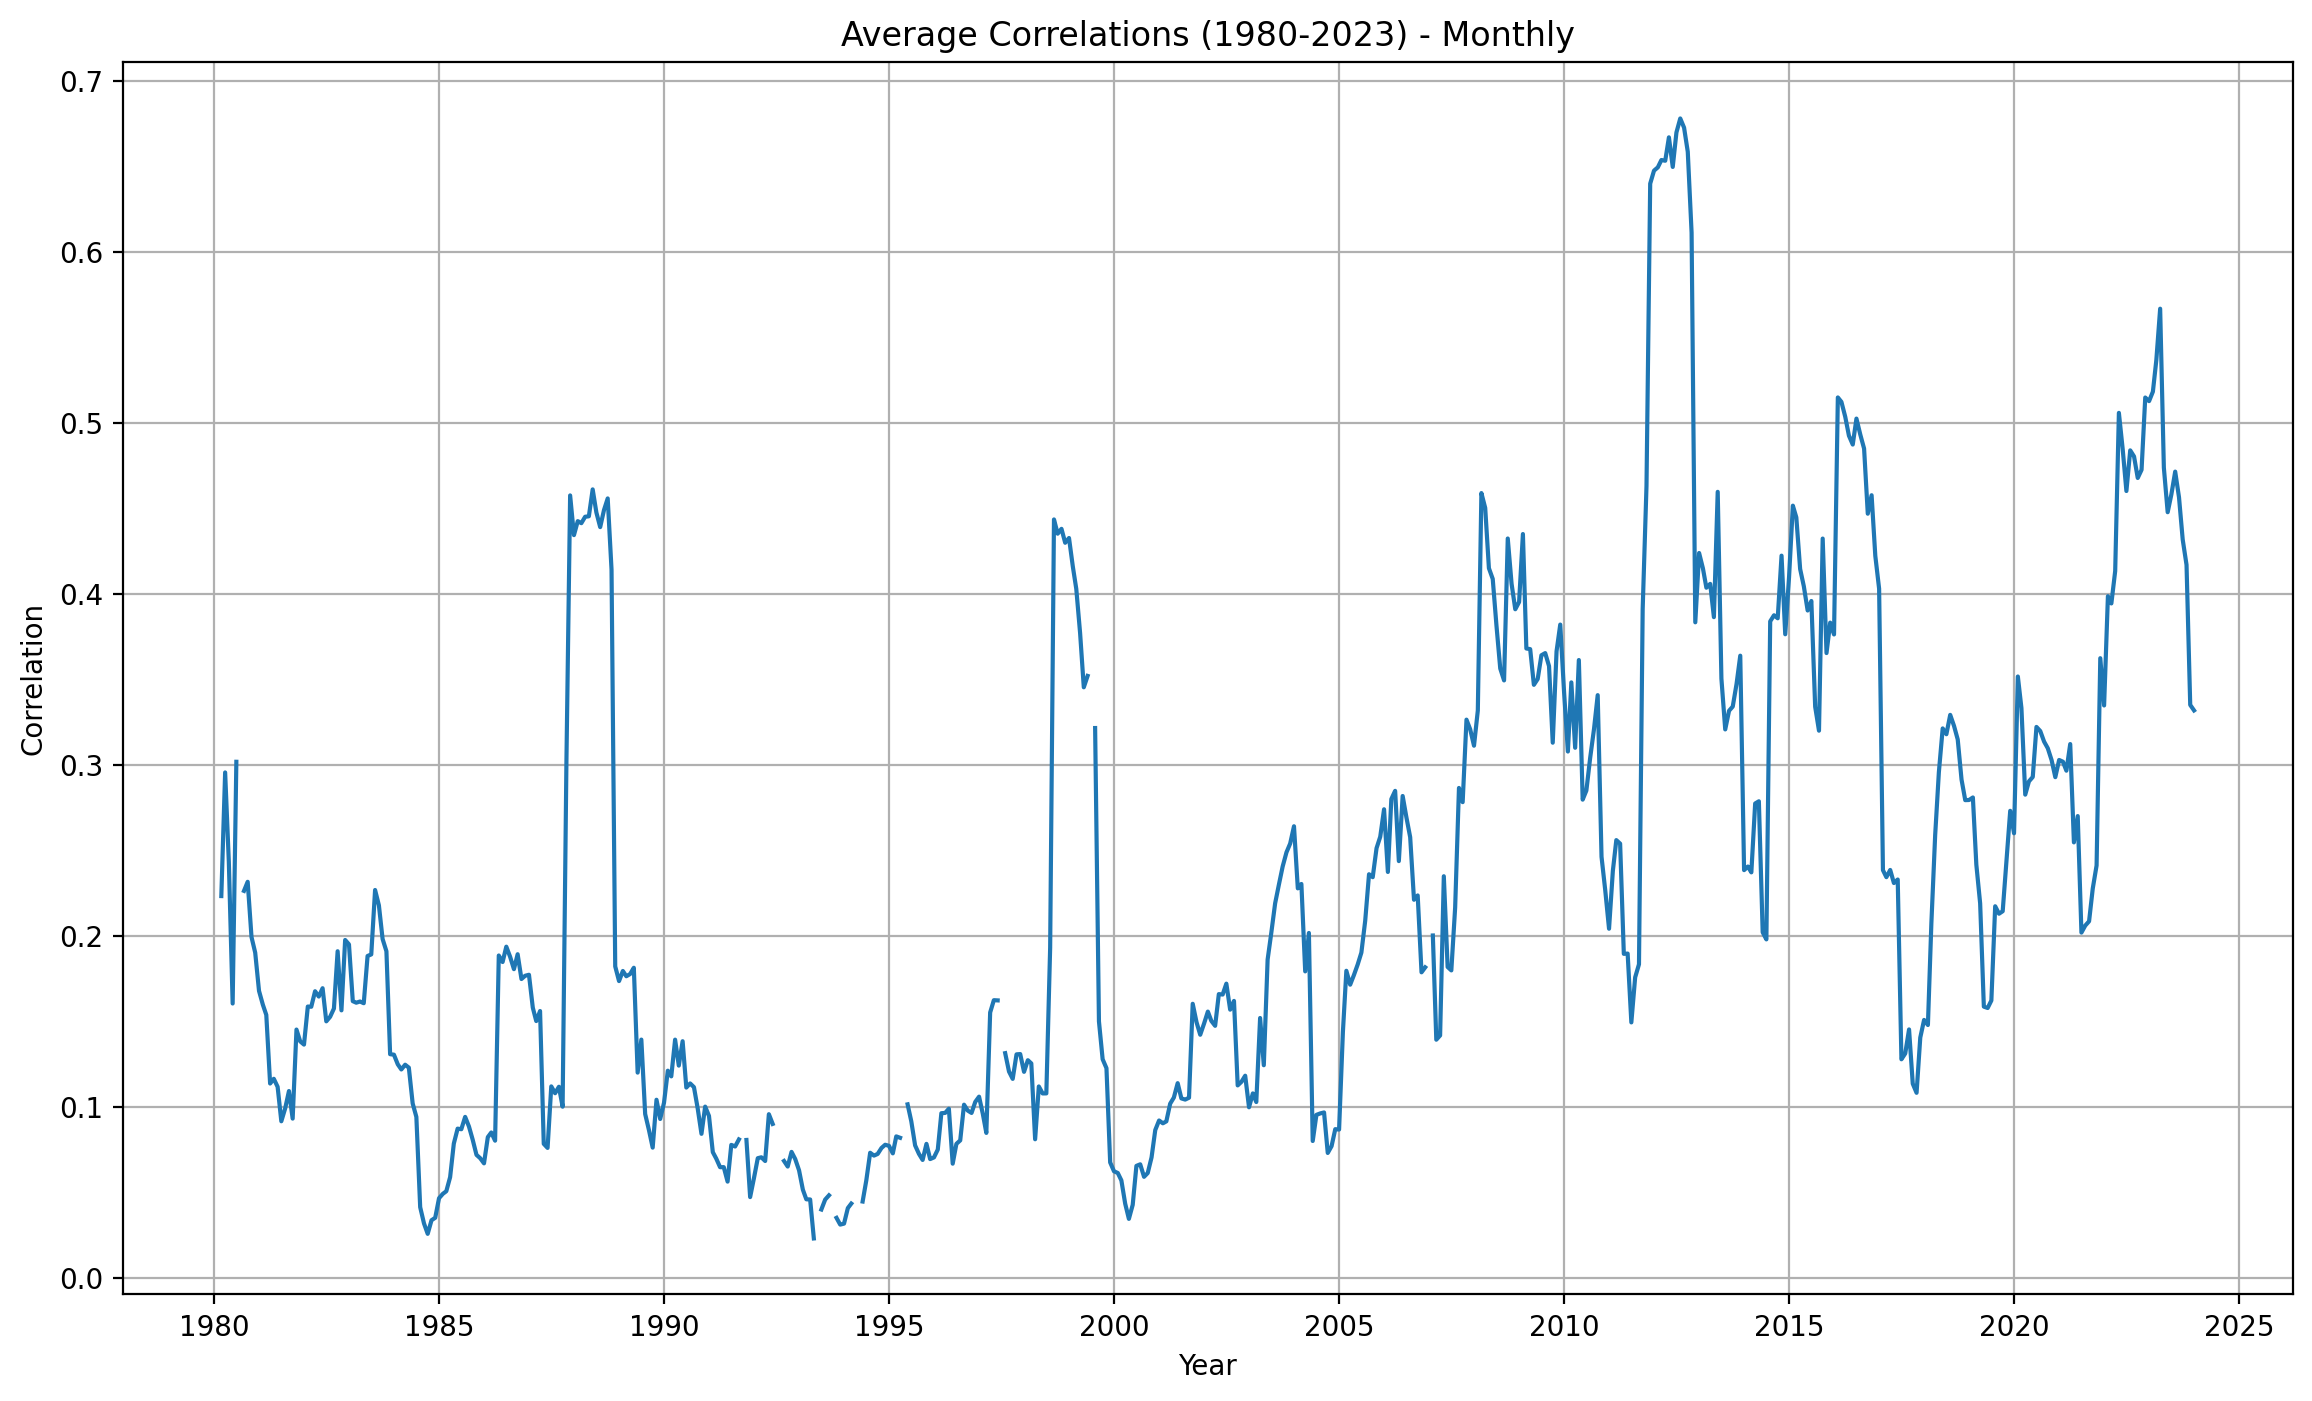

In [18]:
plt.figure(figsize=(14, 8))
plt.plot(mean_date_df_m['Date'],mean_date_df_m['Mean'])
plt.grid()
plt.title('Average Correlations (1980-2023) - Monthly')
plt.xlabel('Year')
plt.ylabel('Correlation')

## Quarterly Correlation

In [19]:
rolling_window = 4 #since there are 4 quarters in a year
Correlation_Matrix = (
    DataCorr
    .resample('Q').last()
    .rolling(window = rolling_window, min_periods=1).corr()
)

In [20]:
unique_dates = Correlation_Matrix.index.get_level_values('Date').unique()
sliced_dfs = []
for date in unique_dates:
    sliced_df = Correlation_Matrix.loc[date]
    sliced_dfs.append(sliced_df)

In [21]:
means = []
for sliced_df in sliced_dfs:
    matrix_array = sliced_df.values
    matrix_mean = np.nanmean(matrix_array)
    means.append(matrix_mean)

In [22]:
mean_date_df_Q = pd.DataFrame({'Date': unique_dates, 'Mean': means})

In [23]:
std_devs = []
for sliced_df in sliced_dfs:
    matrix_array = sliced_df.values
    matrix_std_dev = np.nanstd(matrix_array)
    std_devs.append(matrix_std_dev)

In [24]:
mean_date_df_Q['Standard Deviation'] = std_devs
mean_date_df_Q

,Date,Mean,Standard Deviation
0,1980-03-31,NaN,NaN
1,1980-06-30,0.631821,0.775114
2,1980-09-30,0.473747,0.560030
3,1980-12-31,0.364404,0.500727
4,1981-03-31,0.277074,0.590813
...,...,...,...
171,2022-12-31,0.106150,0.575104
172,2023-03-31,0.516190,0.436118
173,2023-06-30,0.619341,0.390770
174,2023-09-30,0.520384,0.445292


Text(0, 0.5, 'Correlation')

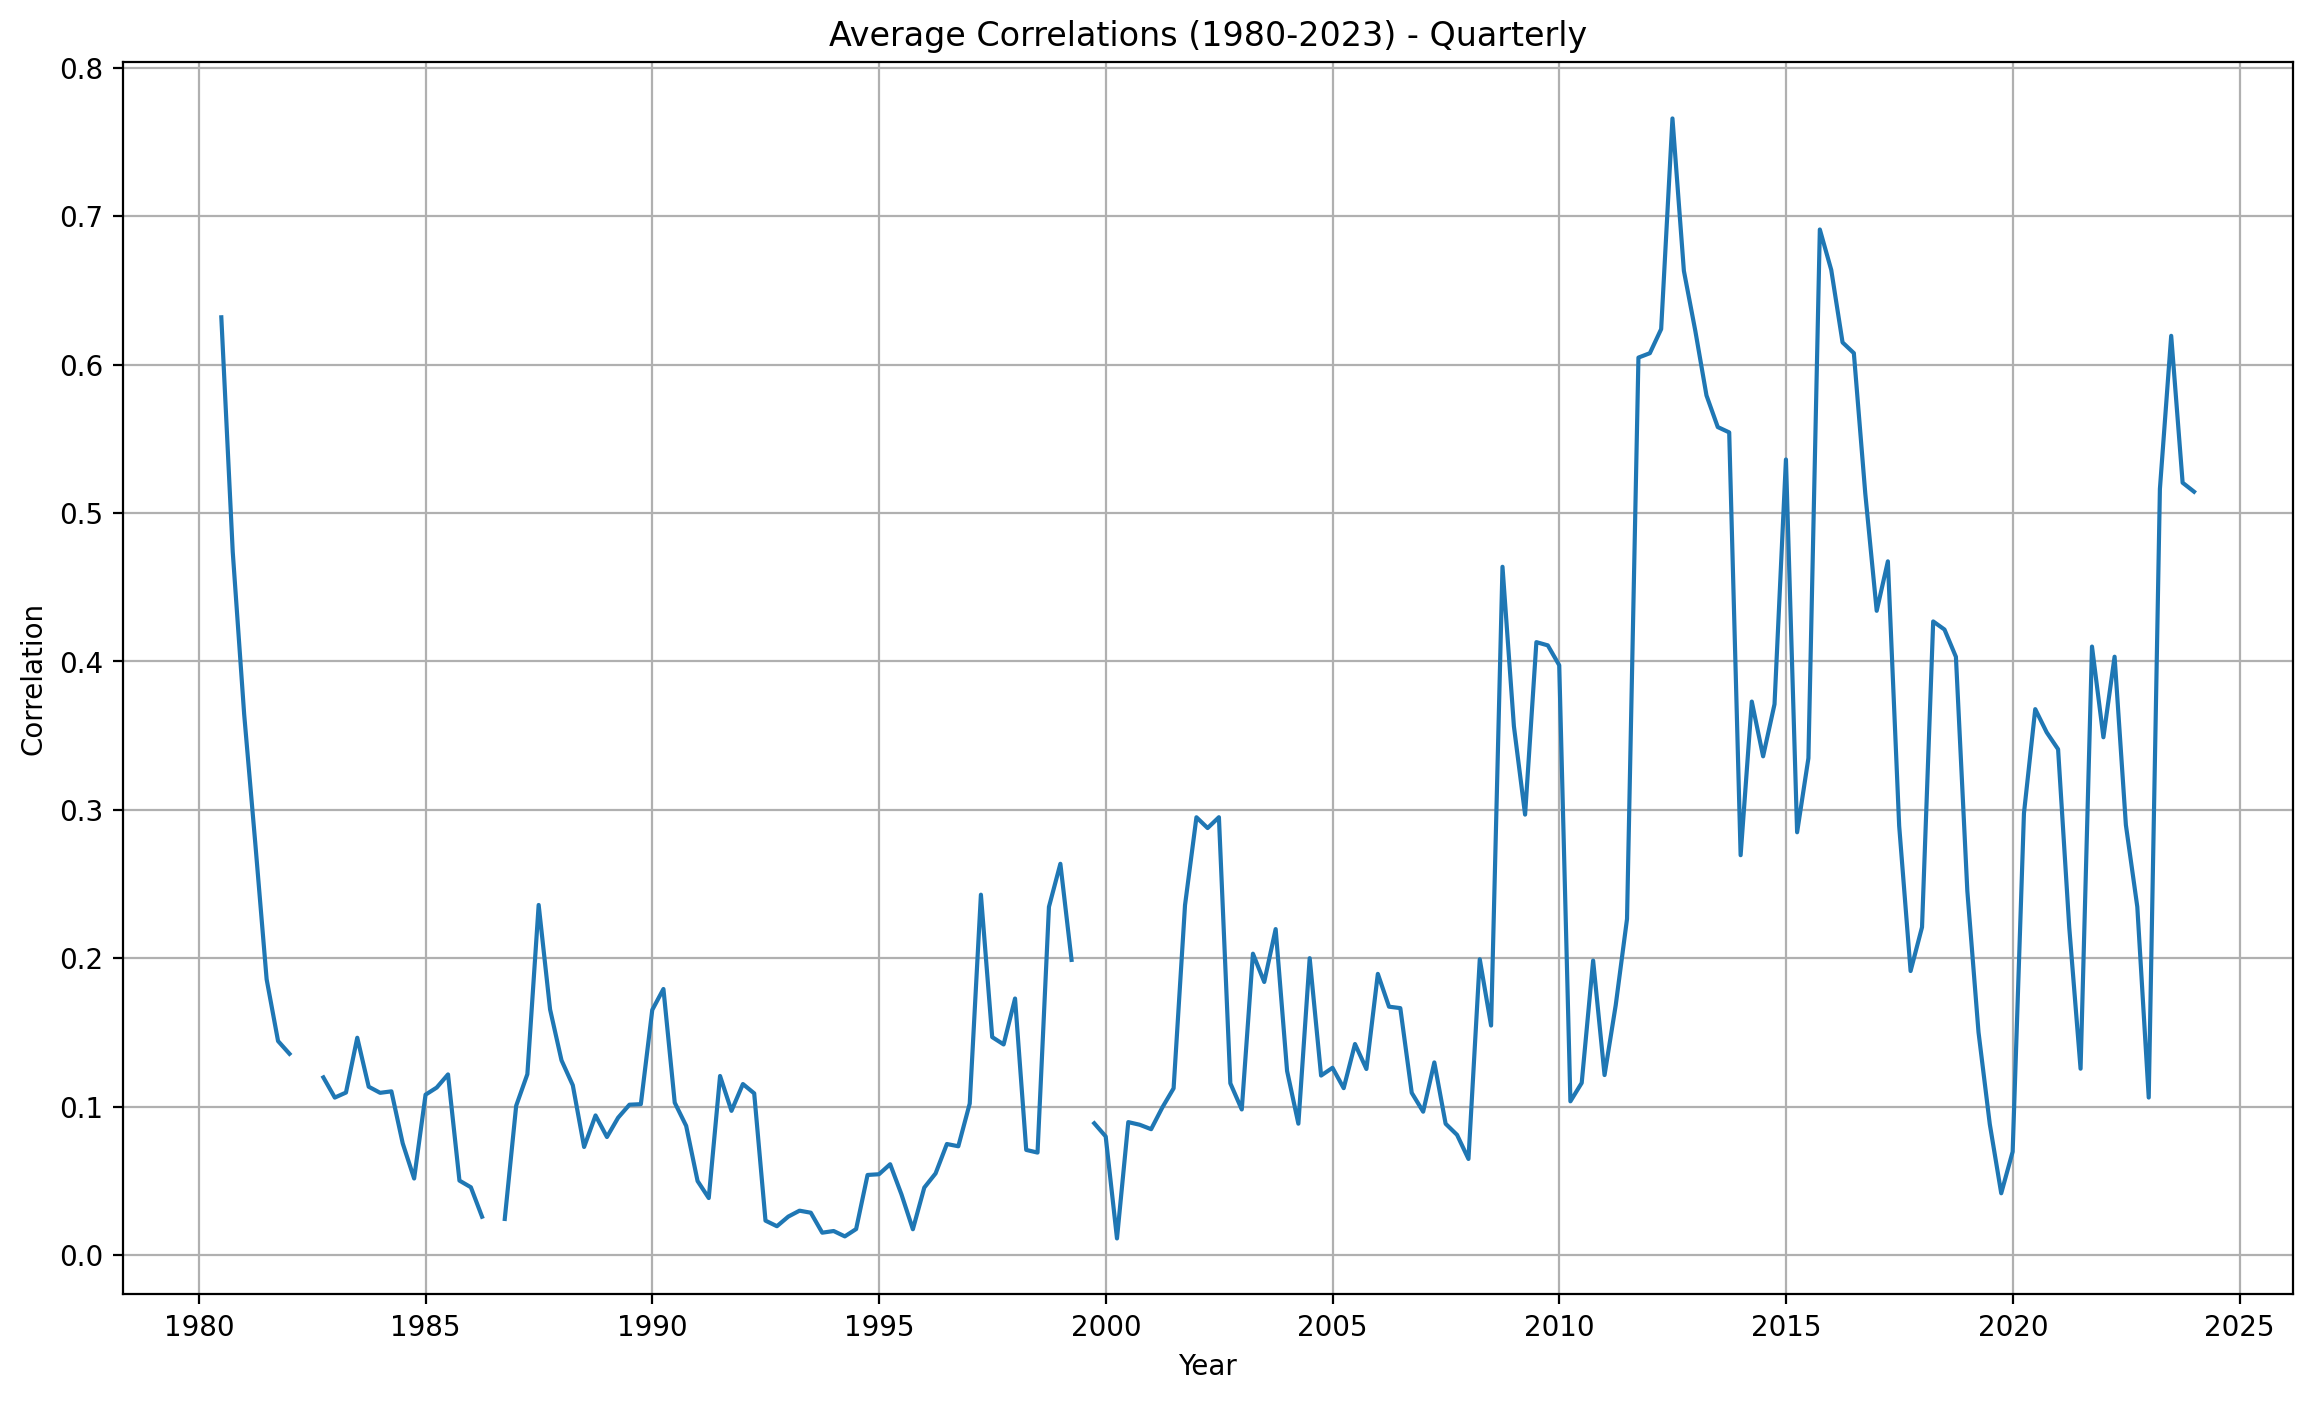

In [25]:
plt.figure(figsize=(14, 8))
plt.plot(mean_date_df_Q['Date'],mean_date_df_Q['Mean'])
plt.grid()
plt.title('Average Correlations (1980-2023) - Quarterly')
plt.xlabel('Year')
plt.ylabel('Correlation')

# Combined Graphs: Correlations & Crisis Periods

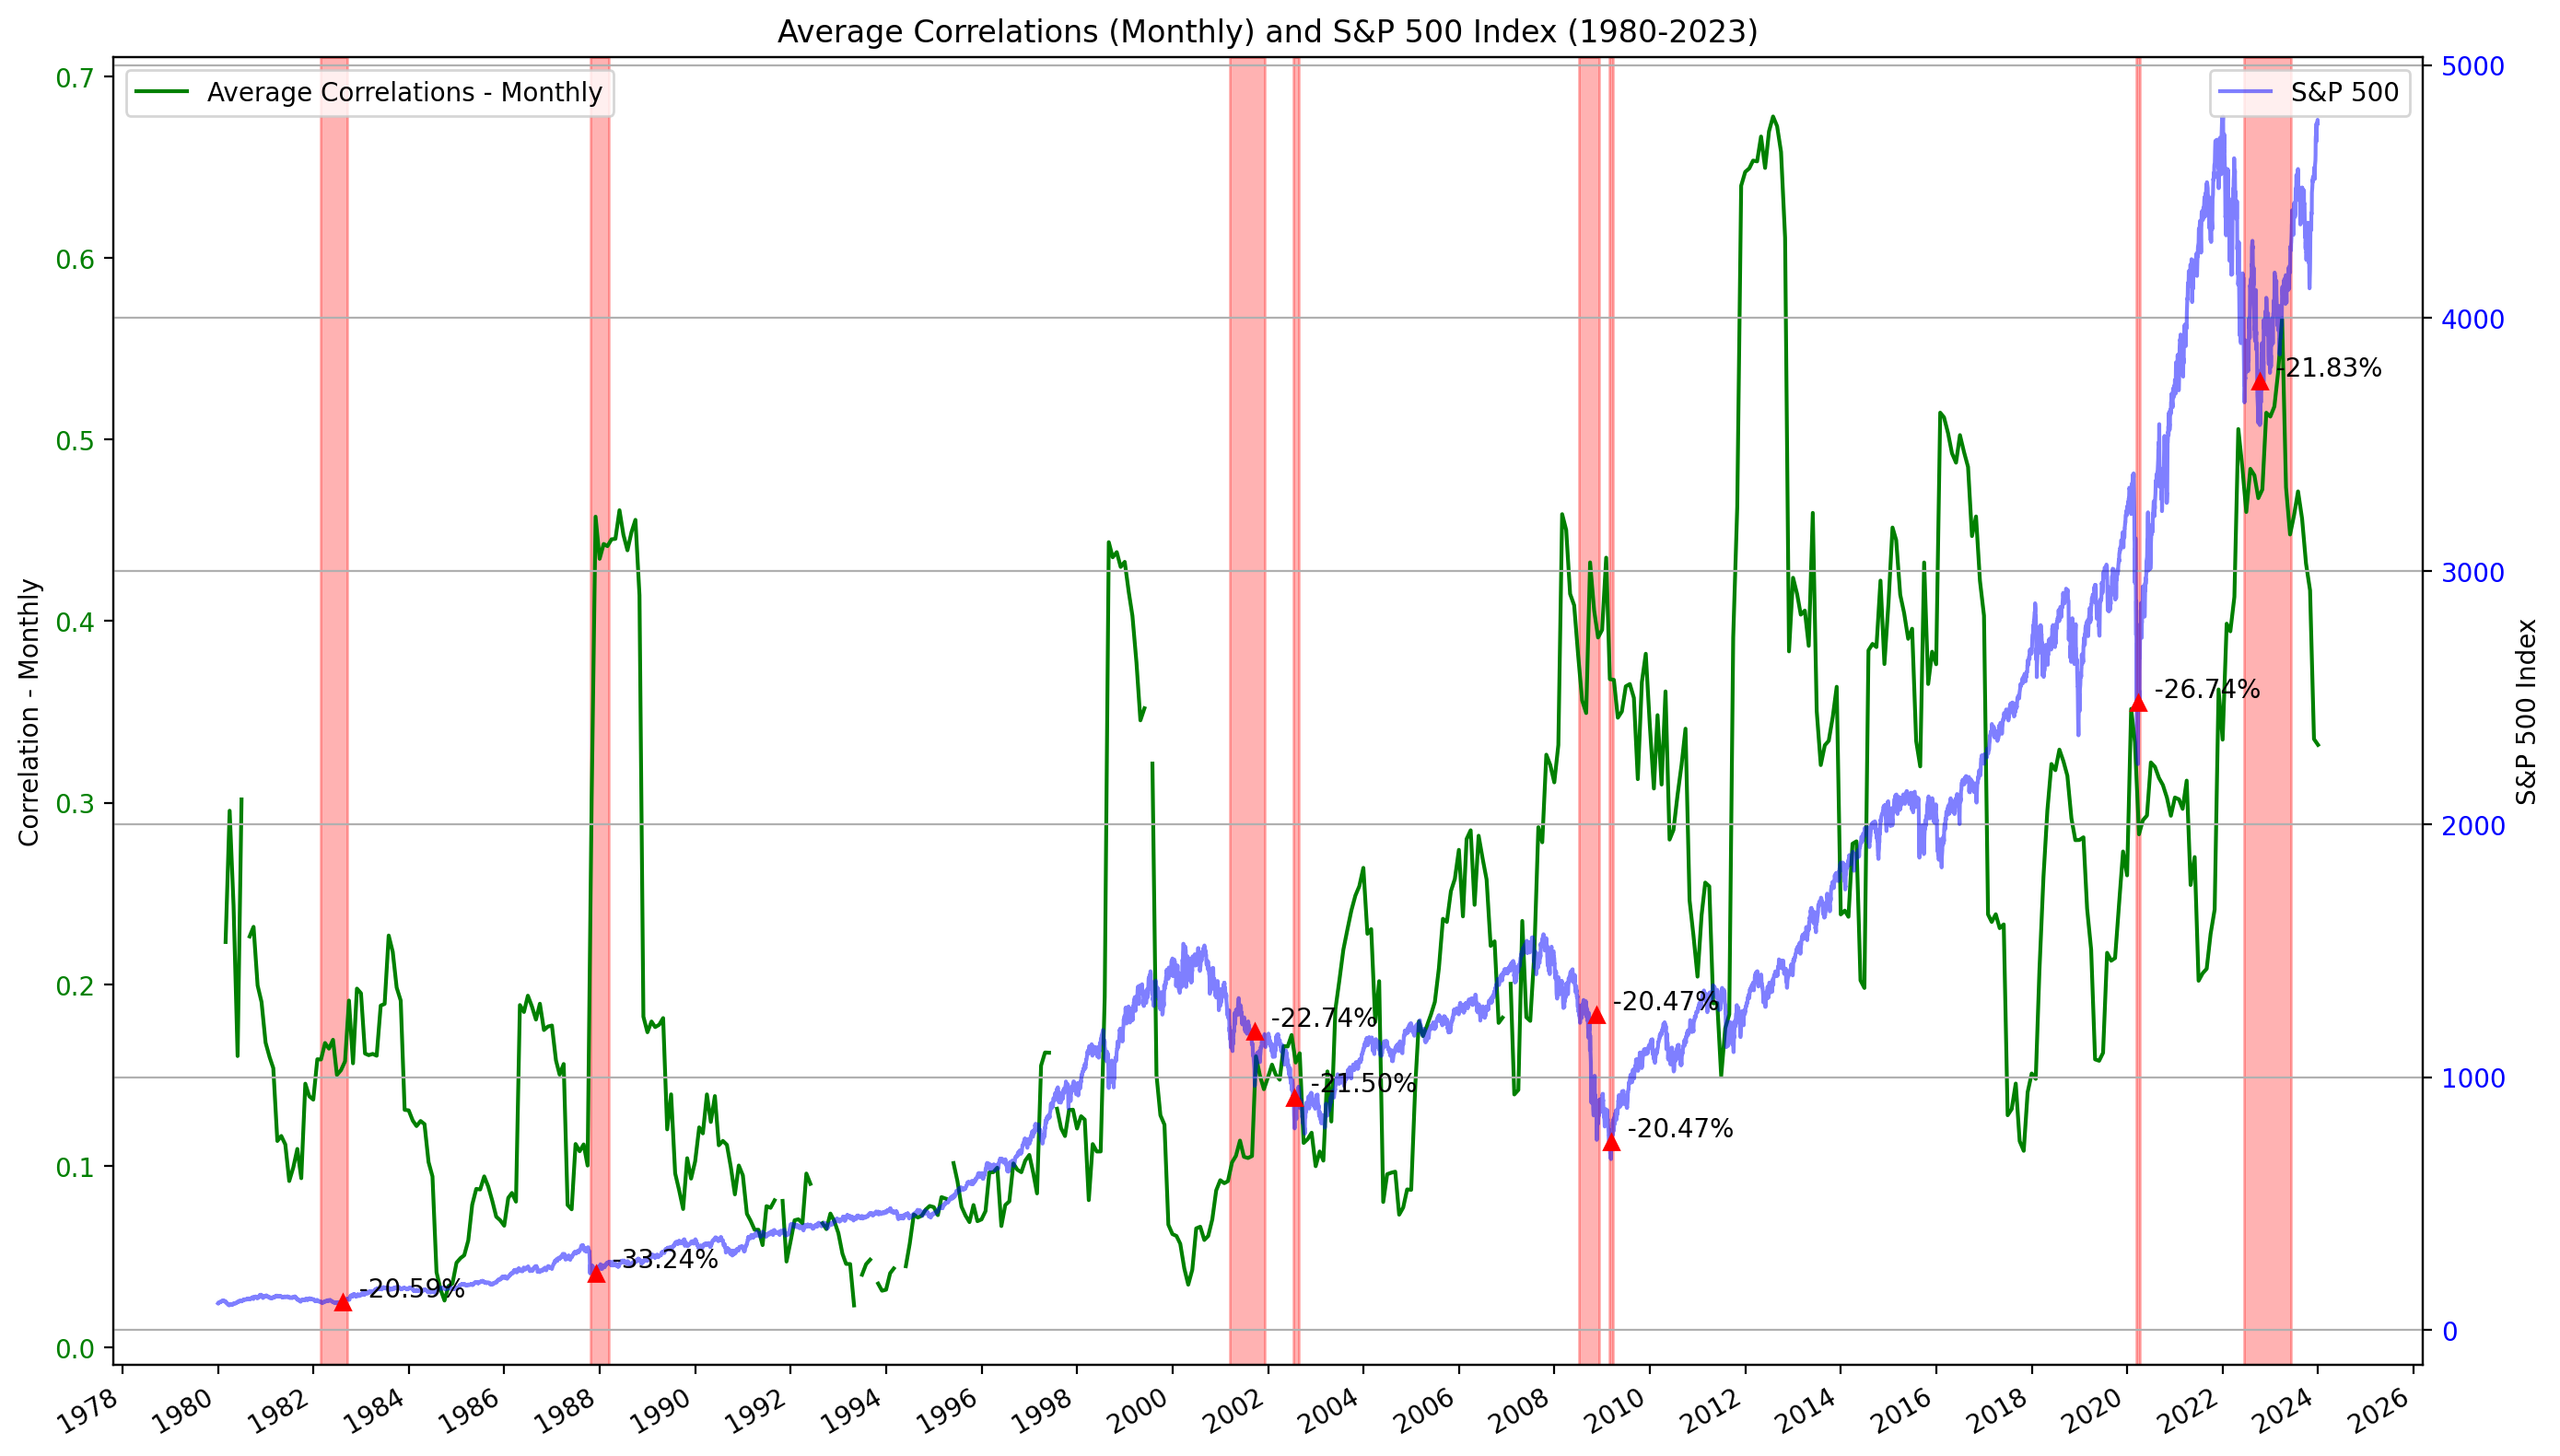

In [26]:
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(mean_date_df_m['Date'], mean_date_df_m['Mean'], label='Average Correlations - Monthly', color='green')
ax1.set_ylabel('Correlation - Monthly')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(filtered_sp500_df['Date'], filtered_sp500_df['^GSPC'], label='S&P 500', color='blue', alpha=0.5)
ax2.set_ylabel('S&P 500 Index')
ax2.tick_params(axis='y', labelcolor='blue')

for _, row in crisis_periods_df.iterrows():
    ax1.axvspan(row['Crisis Start'], row['Crisis End'], color='red', alpha=0.3)
    
for _, row in crisis_periods_df.iterrows():
    peak_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Peak Date']]['^GSPC'].values[0]
    trough_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Crisis Start']]['^GSPC'].values[0]
    percent_drop = ((trough_price - peak_price) / peak_price) * 100
    ax2.plot(row['Trough Date'], trough_price, 'r^')  # Red triangle for trough
    ax2.text(row['Trough Date'], trough_price, f'  {percent_drop:.2f}%', verticalalignment='bottom')

ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()  # Rotation

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average Correlations (Monthly) and S&P 500 Index (1980-2023)')
plt.grid()
plt.tight_layout()
plt.show()

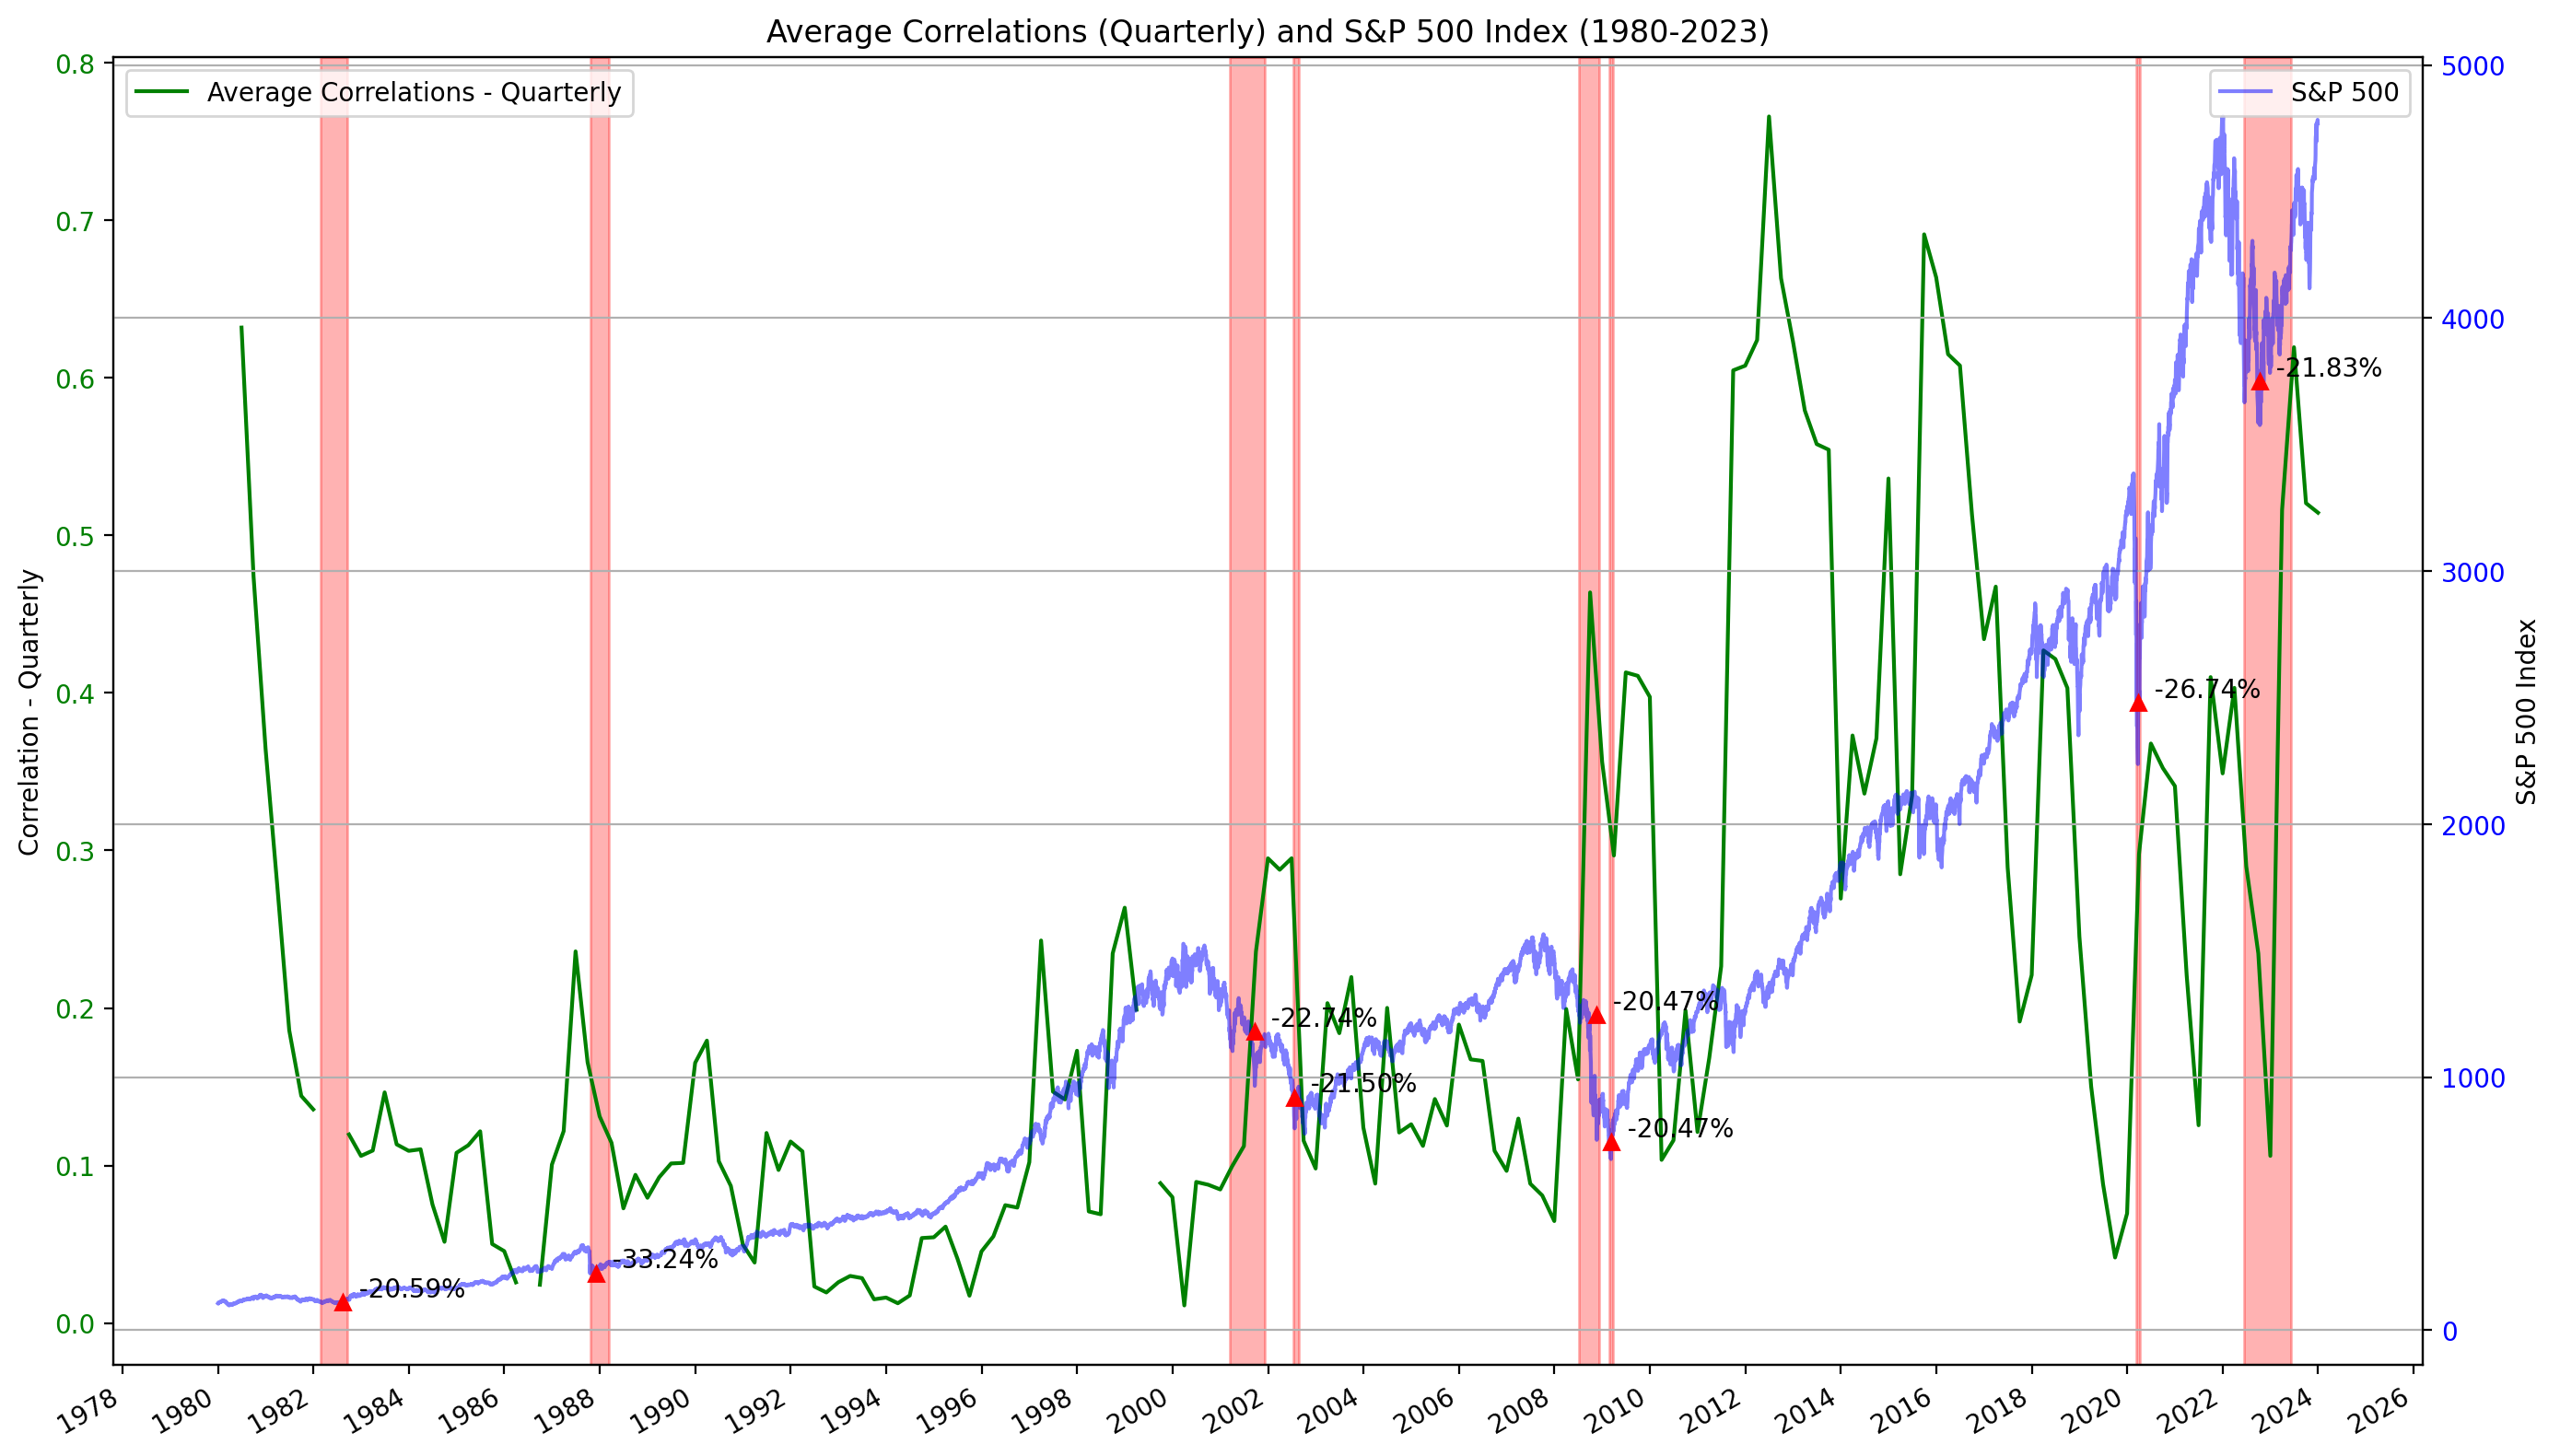

In [27]:
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(mean_date_df_Q['Date'], mean_date_df_Q['Mean'], label='Average Correlations - Quarterly', color='green')
ax1.set_ylabel('Correlation - Quarterly')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(filtered_sp500_df['Date'], filtered_sp500_df['^GSPC'], label='S&P 500', color='blue', alpha=0.5)
ax2.set_ylabel('S&P 500 Index')
ax2.tick_params(axis='y', labelcolor='blue')

for _, row in crisis_periods_df.iterrows():
    ax1.axvspan(row['Crisis Start'], row['Crisis End'], color='red', alpha=0.3)

for _, row in crisis_periods_df.iterrows():
    peak_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Peak Date']]['^GSPC'].values[0]
    trough_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Crisis Start']]['^GSPC'].values[0]
    percent_drop = ((trough_price - peak_price) / peak_price) * 100
    ax2.plot(row['Trough Date'], trough_price, 'r^')  # Red triangle for trough
    ax2.text(row['Trough Date'], trough_price, f'  {percent_drop:.2f}%', verticalalignment='bottom')

ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()  # Rotation

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average Correlations (Quarterly) and S&P 500 Index (1980-2023)')
plt.grid()
plt.tight_layout()
plt.show()

# Analysis: Monthly and Quarterly Correlations -
1. Spikes during crisis periods: Both quarterly and monthly correlations show a spike during crisis periods, but the peaks are less pronounced for quarterly correlations as compared to the monthly data. 
1. Trend during non-crisis periods: Outside the crisis periods, the correlations fluctuate more in the monthly chart than in the quarterly. When not in crisis, it seems the stocks move less in tandem, which could be due to various factors, such as company-specific news or events.
1. Market upswings and correlations: It is interesting to note how the correlation behaves as the market goes up. A rising market with increasing correlations could suggest a general consensus about market growth, whereas a rising market with decreasing correlations could imply that the growth is more selective, with certain sectors leading the way.
1. Implication for diversification: In both charts, we see that average correlations typically increase during periods of market stress and crisis. This reinforces the idea that during downturns, diversification may not work as effectively due to the increased linkage between individual stock movements and the overall market. This is a crucial insight for portfolio construction and risk management.


# Computation of Betas

In [28]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1980-01-01',
        end='2023-12-31',
    )
)


## Monthly Betas

In [29]:
fama_french = ff[0]/100
Data_1 = sp500.loc['1980-01-01':'2023-12-31']
Data_beta = Data_1.drop(Data.columns[-1], axis=1)
excess_returns = Data_beta.subtract(fama_french['RF'], axis=0)
mkt_excess = excess_returns.join(fama_french[['Mkt-RF']])
beta_top = mkt_excess.groupby(pd.Grouper(freq='M')).cov()['Mkt-RF']
beta_bottom = fama_french.resample('M').var()
beta_bottom = beta_bottom['Mkt-RF']
Betas = beta_top/beta_bottom
avg_betas_m = Betas.groupby(level='Date').mean()

## Quarterly Betas

In [30]:
beta_top_Q = mkt_excess.groupby(pd.Grouper(freq='Q')).cov()['Mkt-RF']
beta_bottom_Q = fama_french.resample('Q').var()
beta_bottom_Q = beta_bottom_Q['Mkt-RF']
Betas_Q = beta_top_Q/beta_bottom_Q
avg_betas_Q = Betas_Q.groupby(level='Date').mean()

# Combined Graph: Monthly & Quarterly Beta with Crisis Periods

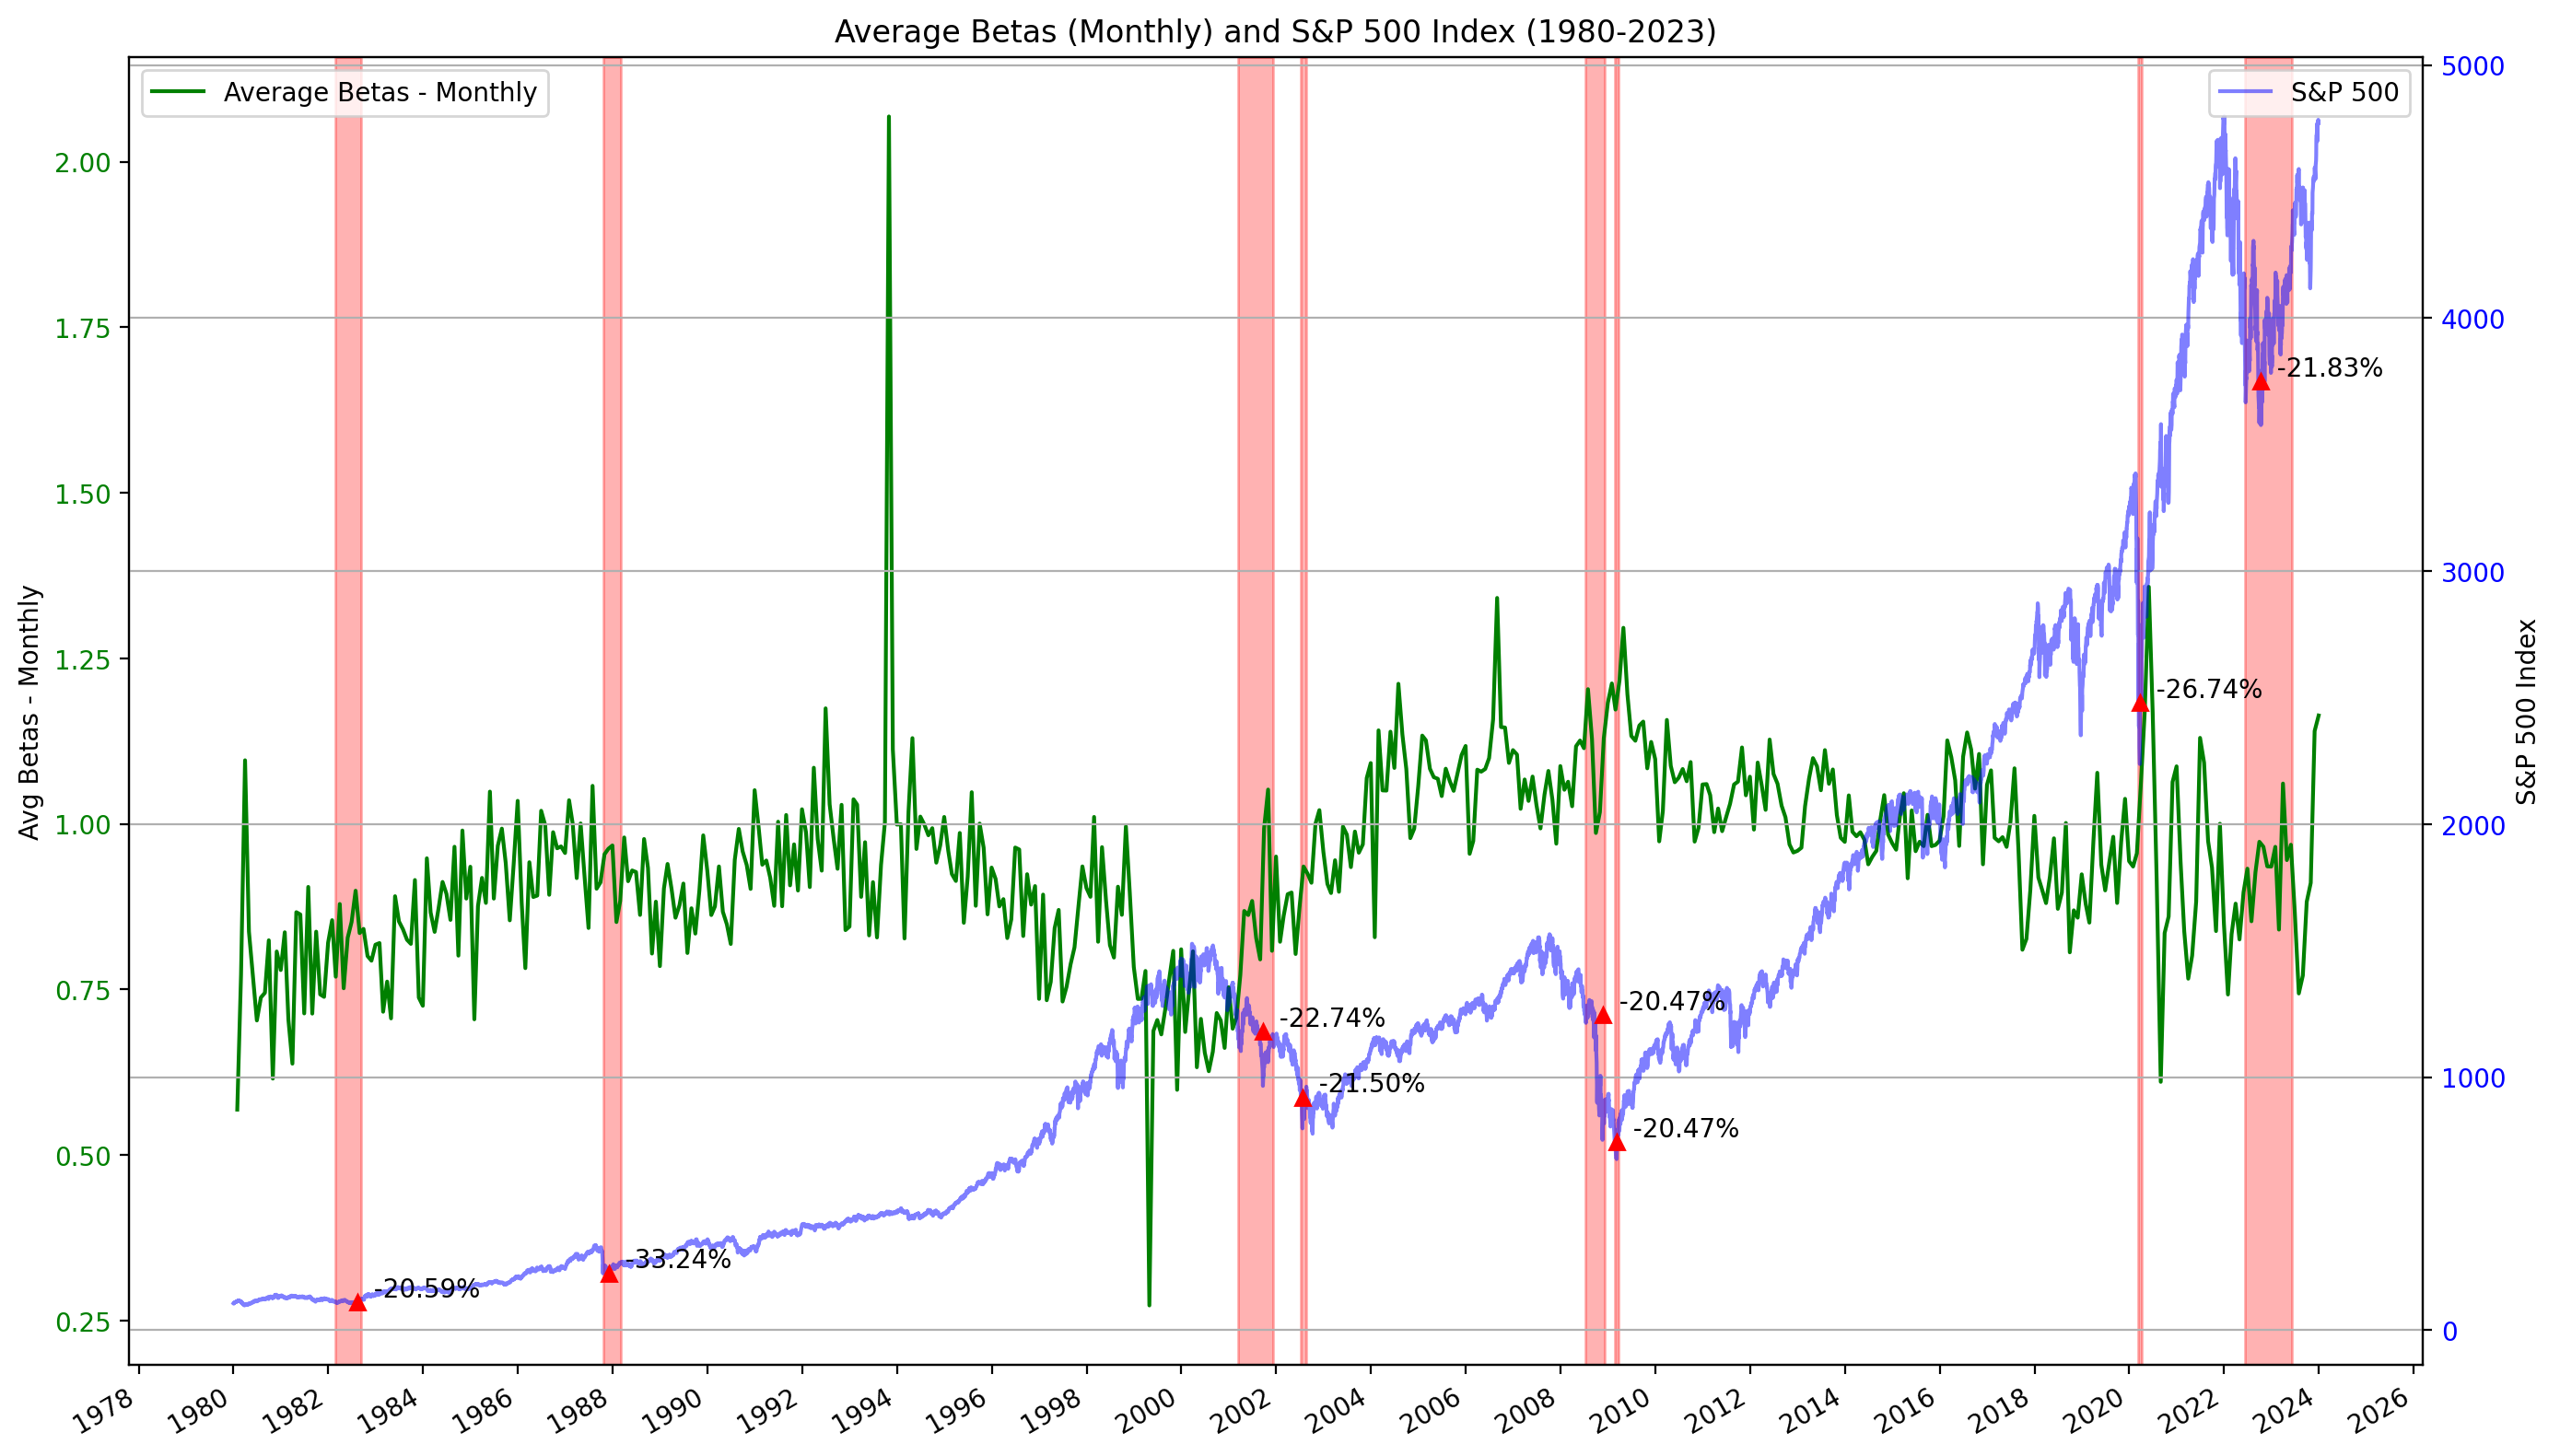

In [31]:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plotting the first graph on the primary y-axis
ax1.plot(avg_betas_m, label='Average Betas - Monthly', color='green')
ax1.set_ylabel('Avg Betas - Monthly')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(filtered_sp500_df['Date'], filtered_sp500_df['^GSPC'], label='S&P 500', color='blue', alpha=0.5)
ax2.set_ylabel('S&P 500 Index')
ax2.tick_params(axis='y', labelcolor='blue')

# Highlighting crisis periods
for _, row in crisis_periods_df.iterrows():
    ax1.axvspan(row['Crisis Start'], row['Crisis End'], color='red', alpha=0.3)

# Adding red pointers for each trough and annotating the % drop
for _, row in crisis_periods_df.iterrows():
    peak_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Peak Date']]['^GSPC'].values[0]
    trough_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Crisis Start']]['^GSPC'].values[0]
    percent_drop = ((trough_price - peak_price) / peak_price) * 100
    ax2.plot(row['Trough Date'], trough_price, 'r^')  # Red triangle for trough
    ax2.text(row['Trough Date'], trough_price, f'  {percent_drop:.2f}%', verticalalignment='bottom')

# Setting x-axis to show every alternate year
ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()  # Rotation

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average Betas (Monthly) and S&P 500 Index (1980-2023)')
plt.grid()
plt.tight_layout()
plt.show()

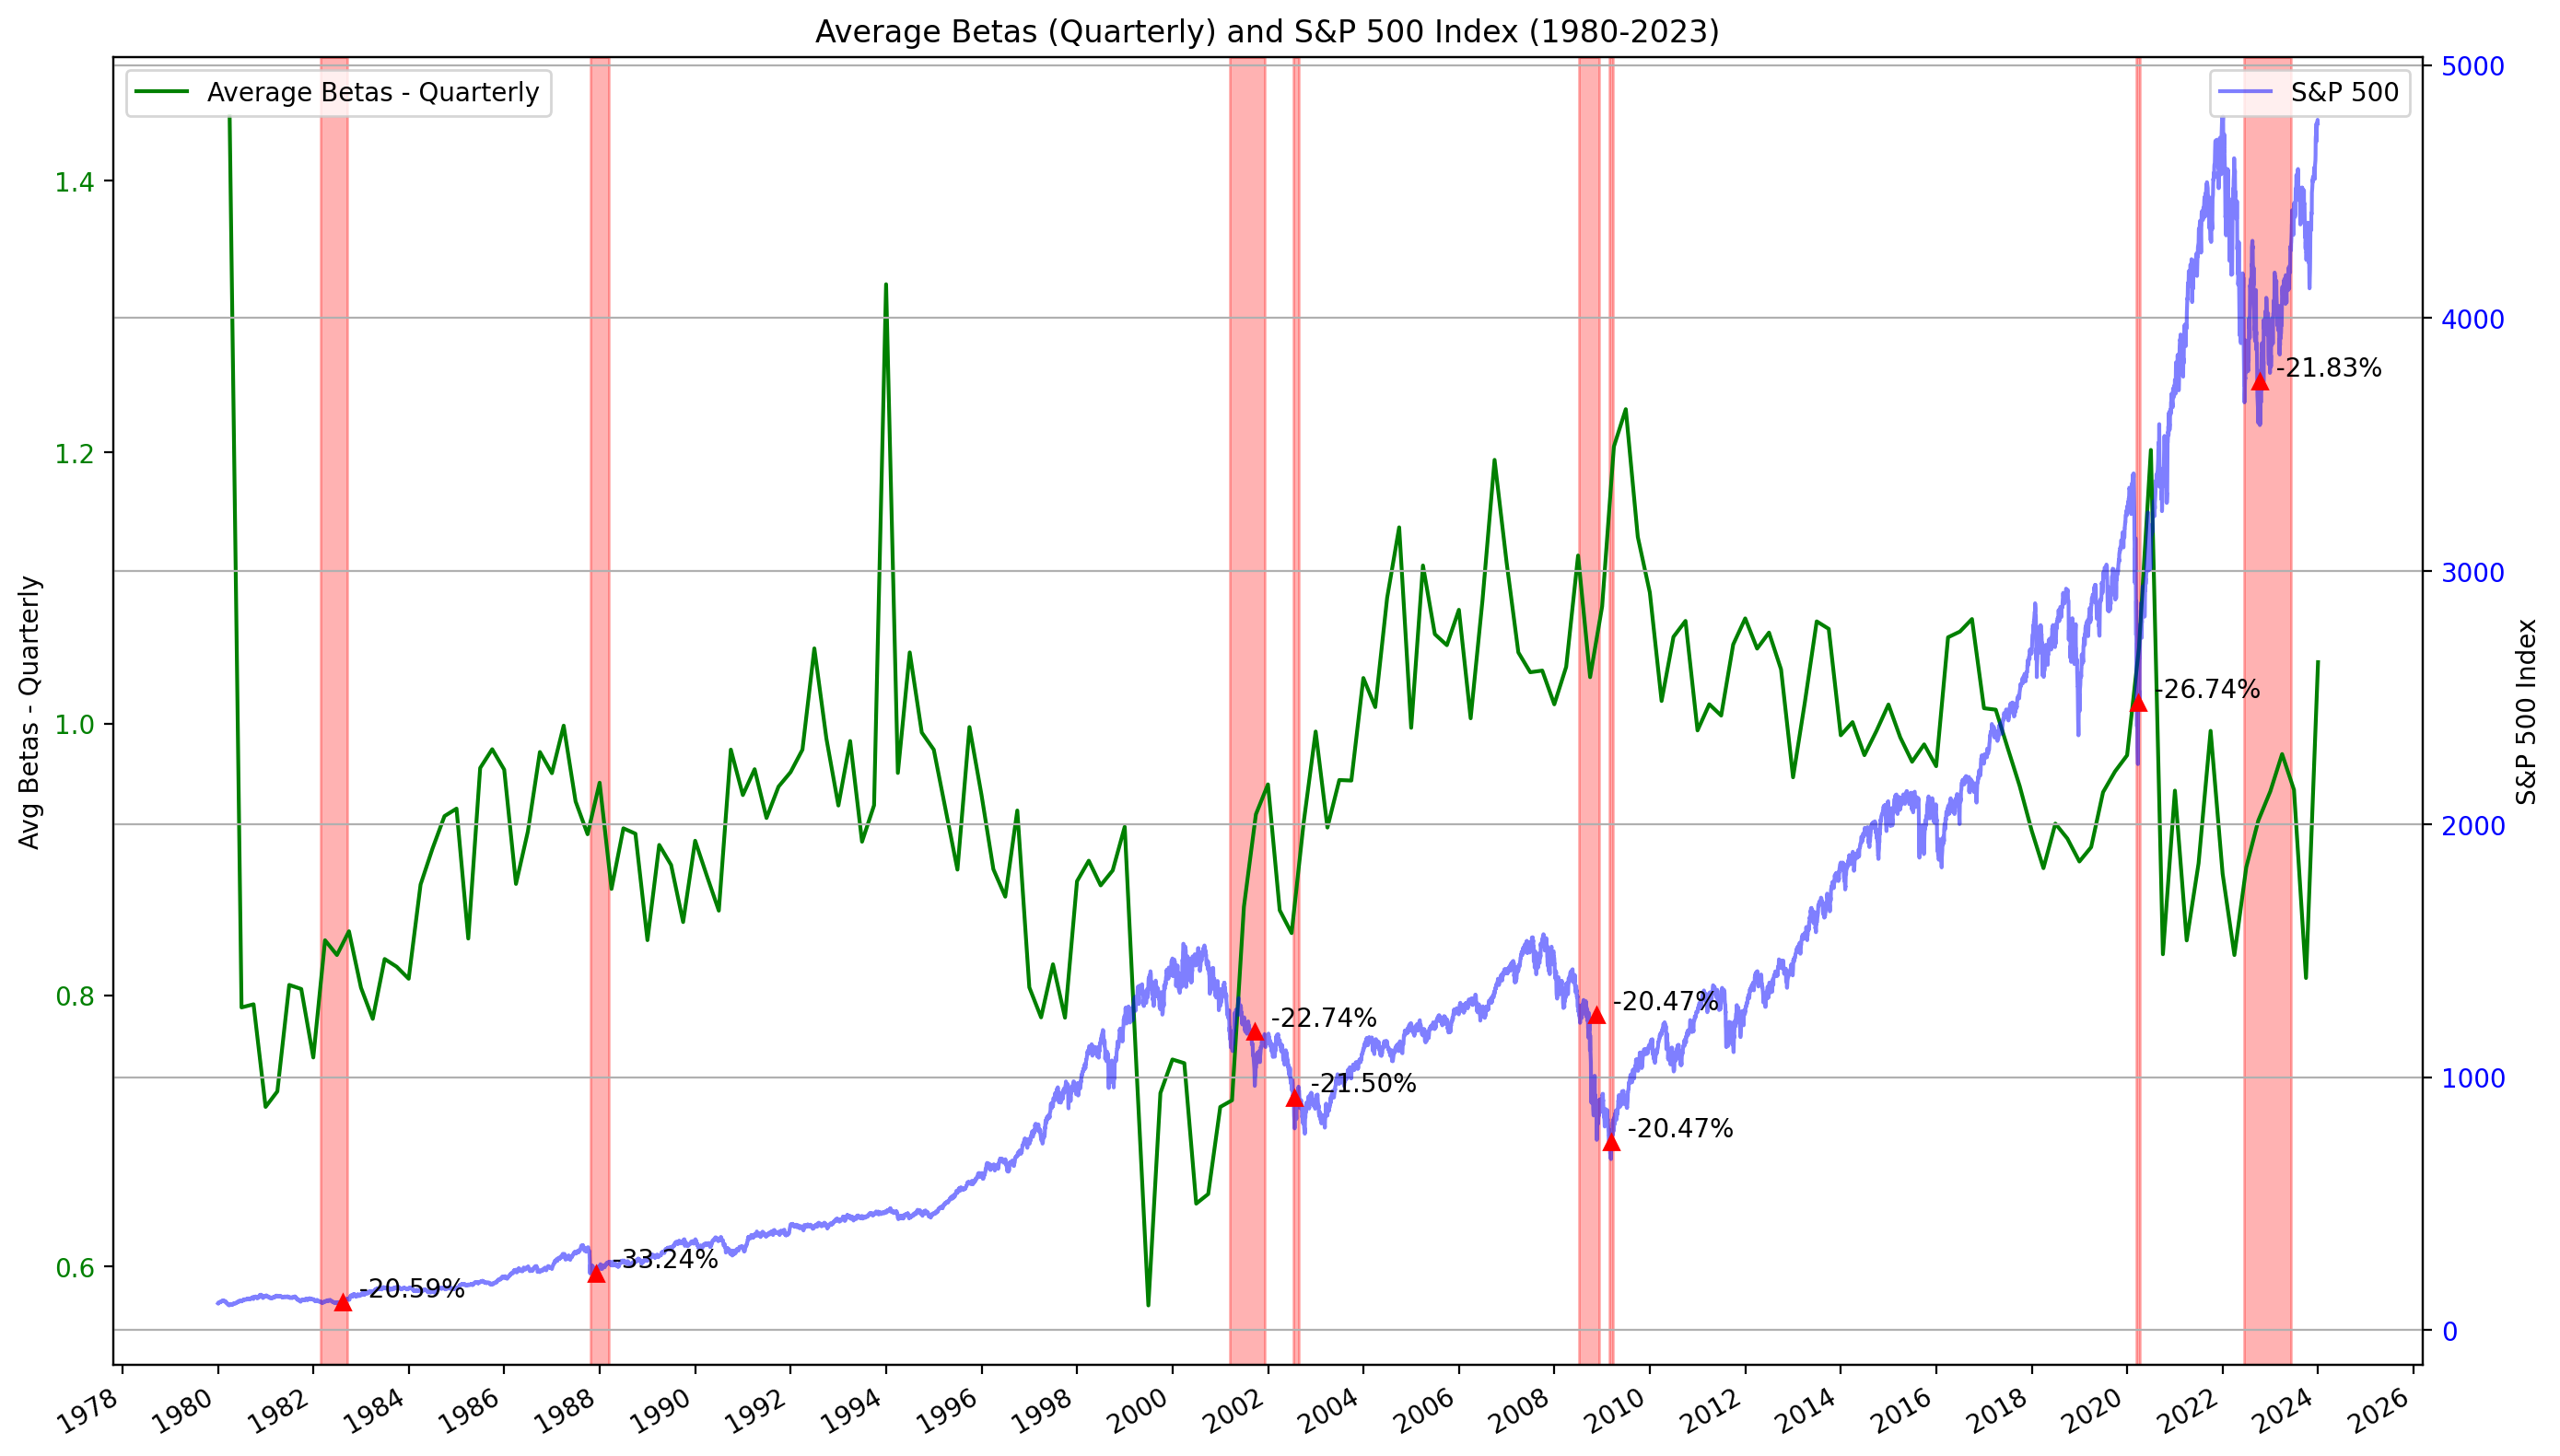

In [32]:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plotting the first graph on the primary y-axis
ax1.plot(avg_betas_Q, label='Average Betas - Quarterly', color='green')
ax1.set_ylabel('Avg Betas - Quarterly')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(filtered_sp500_df['Date'], filtered_sp500_df['^GSPC'], label='S&P 500', color='blue', alpha=0.5)
ax2.set_ylabel('S&P 500 Index')
ax2.tick_params(axis='y', labelcolor='blue')

# Highlighting crisis periods
for _, row in crisis_periods_df.iterrows():
    ax1.axvspan(row['Crisis Start'], row['Crisis End'], color='red', alpha=0.3)

# Adding red pointers for each trough and annotating the % drop
for _, row in crisis_periods_df.iterrows():
    peak_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Peak Date']]['^GSPC'].values[0]
    trough_price = filtered_sp500_df[filtered_sp500_df['Date'] == row['Crisis Start']]['^GSPC'].values[0]
    percent_drop = ((trough_price - peak_price) / peak_price) * 100
    ax2.plot(row['Trough Date'], trough_price, 'r^')  # Red triangle for trough
    ax2.text(row['Trough Date'], trough_price, f'  {percent_drop:.2f}%', verticalalignment='bottom')

# Setting x-axis to show every alternate year
ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()  # Rotation

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average Betas (Quarterly) and S&P 500 Index (1980-2023)')
plt.grid()
plt.tight_layout()
plt.show()

# Descriptive Statistics for Monthly & Quarterly Betas

In [33]:
avg_betas_m.describe()

count    528.000000
mean       0.943527
std        0.137291
min        0.272714
25%        0.862436
50%        0.949105
75%        1.029171
max        2.068387
Name: Mkt-RF, dtype: float64

In [34]:
avg_betas_Q.describe()

count    176.000000
mean       0.948585
std        0.120345
min        0.571392
25%        0.883374
50%        0.953770
75%        1.014057
max        1.447177
Name: Mkt-RF, dtype: float64

# Analysis: Monthly and Quarterly Betas -  
1. Volatility: Monthly betas seem to have more volatility as compared to the quarterly betas.
1. Crisis correlation: There is a visible relationship between the market downturns and spikes in the betas, especially during the crisis periods. 
1. Crisis response time: Monthly betas react more quickly to the onset of a crisis, while quarterly betas may show a delayed response.
1. Correlation during non-crisis periods: During bull markets, both monthly and quarterly betas seem to trend lower or stay flat, suggesting that individual stocks might be moving independently from the market. 


# Limitations
1.	Survivorship Bias
This refers to a situation where we only show the partial truth and not the whole story. 
In our case, this occurs because a lot of the companies did not exist at the time i.e. during the 1980s or were in their initial stages. 
This shows a flaw in our data set and therefore the correlations that we found out wouldn’t be 100% accurate. Essentially, we cannot identify the proper winners and losers using this data set.

1.	Lot of NAN values
This again emphasizes a notable flaw in our data set which, as mentioned above, is due to the inexistence of certain organizations at the time, further restricting us to find out the accurate correlations between the S&P 500 and the returns on the stocks.


# Conclusion
1.	Survivorship Bias
This refers to a situation where we only show the partial truth and not the whole story. 
In our case, this occurs because a lot of the companies did not exist at the time i.e. during the 1980s or were in their initial stages. 
This shows a flaw in our data set and therefore the correlations that we found out wouldn’t be 100% accurate. Essentially, we cannot identify the proper winners and losers using this data set.

1.	Lot of NAN values
This again emphasizes a notable flaw in our data set which, as mentioned above, is due to the inexistence of certain organizations at the time, further restricting us to find out the accurate correlations between the S&P 500 and the returns on the stocks.
